Hunter Bennett | Glass Lab | Kupffer Strains Project | 10 March 2021 

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat
from homer_preprocessing import read_annotated_peaks

# Set working directory

In [3]:
dataDirectory = '/home/h1bennet/strains/data/PU1/control/'
inputDirectory = '/home/h1bennet/strains/data/input/'
workingDirectory = '/home/h1bennet/strains/results/00_Strains_Control_PU1/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# We will start by using O'young's script to get the IDR peaks for each condition
____
These are rather annoying to make in my opinion but for the sake of consistancy with Ty we will use these going forward. Their structure is as follows:
* Column 1: Group ID
* Column 2: Color for analysis
* Column 3: absolute path to files on epiglass for each sample in group, separated by semicolon
* Column 4: corresponding short name for each sample in group, separated by semicolon

Colors
* C57Bl6/J: #4daf4a
* Balbc/J: #3773b8
* AJ: #e41a1c

The output of peakIDR.R includes many things, the main thing we use are the final .idr peak files for each group


In [4]:
c57_paths = [
    dataDirectory+'c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423',
    dataDirectory+'mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat']
balbc_paths = [
    dataDirectory+'balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208',
    dataDirectory+'balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915']

c57_input_paths = [
    inputDirectory+'c57bl6j_M_Kupffer_ChIP_input_NoTx_JSSTDT_PC231B232APool_JSS_s20170713',
    inputDirectory+'c57bl6j_M_Kupffer_ChIP_input_NoTx_JSSTDT_PC231B232APool_JSS_s20170713']

balbc_input_paths = [
    inputDirectory+'balb_M_Tim4PKup_ChIP_input_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915',
    inputDirectory+'balb_M_Tim4PKup_ChIP_input_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915']

In [5]:
c57_ids = ['c57bl6j_kupffer_control_pu1_Pool',
           'c57bl6j_kupffer_control_pu1_PC231A']

balbc_ids = ['balbcj_kupffer_control_pu1_BALB11AB',
             'balbcj_kupffer_control_pu1_BALB10ABC']

In [6]:
ids = ['c57bl6j_kupffer_control_pu1',
       'balbcj_kupffer_control_pu1']
colors = ['#4daf4a',
          '#3773b8']
paths = [';'.join(c57_paths),
         ';'.join(balbc_paths)]
short_ids = [';'.join(c57_ids),
             ';'.join(balbc_ids)]
input_paths = [';'.join(c57_input_paths),
               ';'.join(balbc_input_paths)]

In [7]:
pd.DataFrame([ids,colors,paths,short_ids,input_paths]).T.to_csv(
    './sampleDef.txt',
    sep='\t',
    header=False,
    index=False)

In [8]:
pd.DataFrame([ids,colors,paths,short_ids,input_paths]).T

,0,1,2,3,4
0,c57bl6j_kupffer_control_pu1,#4daf4a,/home/h1bennet/strains/data/PU1/control/c57bl6...,c57bl6j_kupffer_control_pu1_Pool;c57bl6j_kupff...,/home/h1bennet/strains/data/input/c57bl6j_M_Ku...
1,balbcj_kupffer_control_pu1,#3773b8,/home/h1bennet/strains/data/PU1/control/balbcj...,balbcj_kupffer_control_pu1_BALB11AB;balbcj_kup...,/home/h1bennet/strains/data/input/balb_M_Tim4P...


Run: peakIDR.R sampleDef.txt in the r-ouyangPipe environment, then continue

    source activate r-ouyangPipe
    
    mkdir ./idr_peaks/

    peakIDR.R sampleDef.txt -a chip -o ./idr_peaks/

In [9]:
# %%bash
# # if directories don't exist, create them
# if [ ! -d ./atac_peak_files/ ]; then mkdir ./atac_peak_files; fi
# # move IDR peaks into atac_peak_folder
# mv *kupffer*.idr ./atac_peak_files

### Merge peaks

In [10]:
if not os.path.isdir('./merged_peaks/'):
    os.mkdir('./merged_peaks/')

In [16]:
with open('./mergePeaks_homer.sh', 'w') as f:
    peakfiles = np.sort(['./idr_peaks/balbcj_kupffer_control_pu1_peaks.idr',
                         './idr_peaks/c57bl6j_kupffer_control_pu1_peaks.idr'])
    merge_peaks = ['mergePeaks', '-d', 'given',
                   ' '.join(peakfiles), '>',
                   './merged_peaks/idr_peaks_merged.txt', '\n']
    f.write(' '.join(merge_peaks))    
f.close()

# Annotate peaks

In [17]:
# grab relevant tag directories
tagdirs = np.sort(glob.glob('/home/h1bennet/strains/data/PU1/control/*'))

drop_files = ['AJ']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

Create script to annotate peaks with HOMER - its possible that this is resizing the peaks and thats why downstream we dont have to do anything

In [18]:
with open('./annotatePeaks_homer.sh', 'w') as f:
    annotate_raw = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-raw', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_raw_idr_peaks_merged.txt &\n\n']
    
    annotate_norm = ['annotatePeaks.pl', './merged_peaks/idr_peaks_merged.txt',
                       'mm10', '-size 200', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_norm_idr_peaks_merged.txt &\n']
    
    annotate_prom = ['annotatePeaks.pl', 'tss', 'mm10', '-norm 1e7', '-d \\\n',
                       ' \\\n'.join(tagdirs), '>',
                       './merged_peaks/ann_promoters_atac.txt &\n\n']
    
    f.write(' '.join(annotate_raw))    
    f.write(' '.join(annotate_norm))
    f.write(' '.join(annotate_prom))
    
    f.close()

# Summary plots

In [19]:
# make folder for figures
if not os.path.isdir('./figures'):
    os.mkdir('./figures')

### Read in annotation files

In [20]:
# import annotation file
df, mat = read_annotated_peaks('./merged_peaks/ann_norm_idr_peaks_merged.txt')

# shorten columns to make labeling nicer
mat.columns = mat.columns.str.split('/').str[-1]

# quantile normalize data
mat_quant = quantile_normalize_df(mat)

Filter low tag peaks

In [22]:
# use group based mat filter - have to set manually
print(mat.shape[0], 'total peaks')
print('filtering low tag count peaks')
groups=[[0,1],[2,3]]
peaks = []
for group in groups:
    peaks.extend(mat.loc[mat.iloc[:, group].mean(1) > 5, :].index.tolist())
mat = mat.reindex(list(set(peaks)))
mat = mat.dropna(how='all')
mat_quant = mat_quant.reindex(list(set(peaks)))
mat_quant = mat_quant.dropna(how='all')
print(mat.shape[0], 'total peaks')

50443 total peaks
filtering low tag count peaks
50442 total peaks


### Mean variance plot

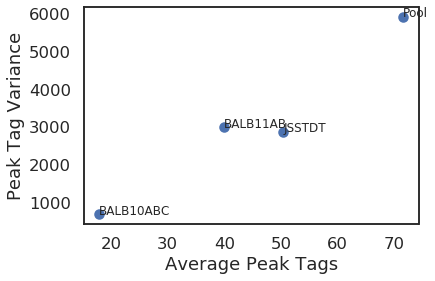

In [28]:
ax = plt.scatter(mat.mean(), mat.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat.mean(),
            mat.var(),
            mat_quant.columns.str.split('_').str[7],
            plt.gca())

plt.savefig('./figures/mean_variance_plot.png',
            bbox_inches='tight')

### Try with quantile normalized data

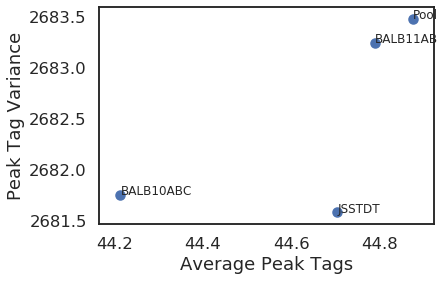

In [30]:
ax = plt.scatter(mat_quant.mean(), mat_quant.var())
plt.xlabel('Average Peak Tags')
plt.ylabel('Peak Tag Variance')
label_point(mat_quant.mean(),
            mat_quant.var(),
            mat_quant.columns.str.split('_').str[7],
            plt.gca())

plt.savefig('./figures/mean_variance_plot_quantnorm.png',
            bbox_inches='tight')

### Scatter plot

In [31]:
# g = sns.PairGrid(np.log2(mat+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter.png', bbox_inches='tight')

In [32]:
# g = sns.PairGrid(np.log2(mat_quant+1), height=10)
# g.map(plt.scatter);
# plt.savefig('./figures/atac_corr_scatter_quantnorm.png', bbox_inches='tight')

### Correlation heatmap

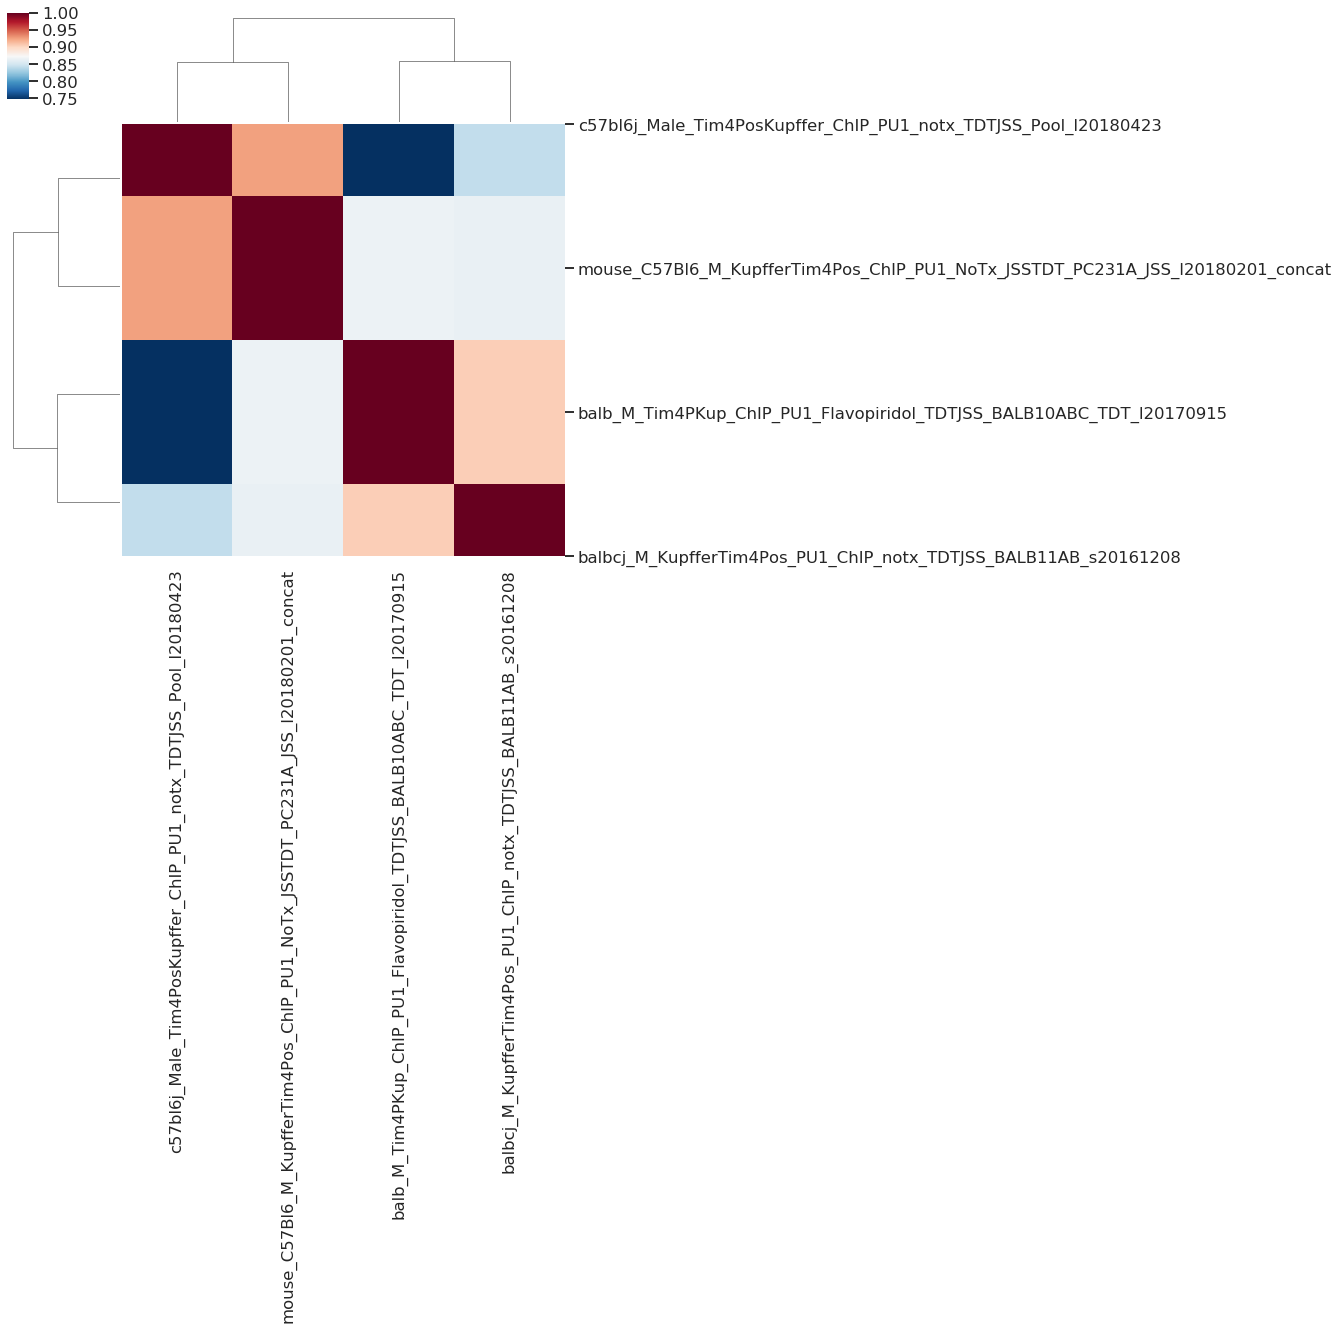

In [33]:
cm = sns.clustermap(mat.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap.png', bbox_inches='tight')

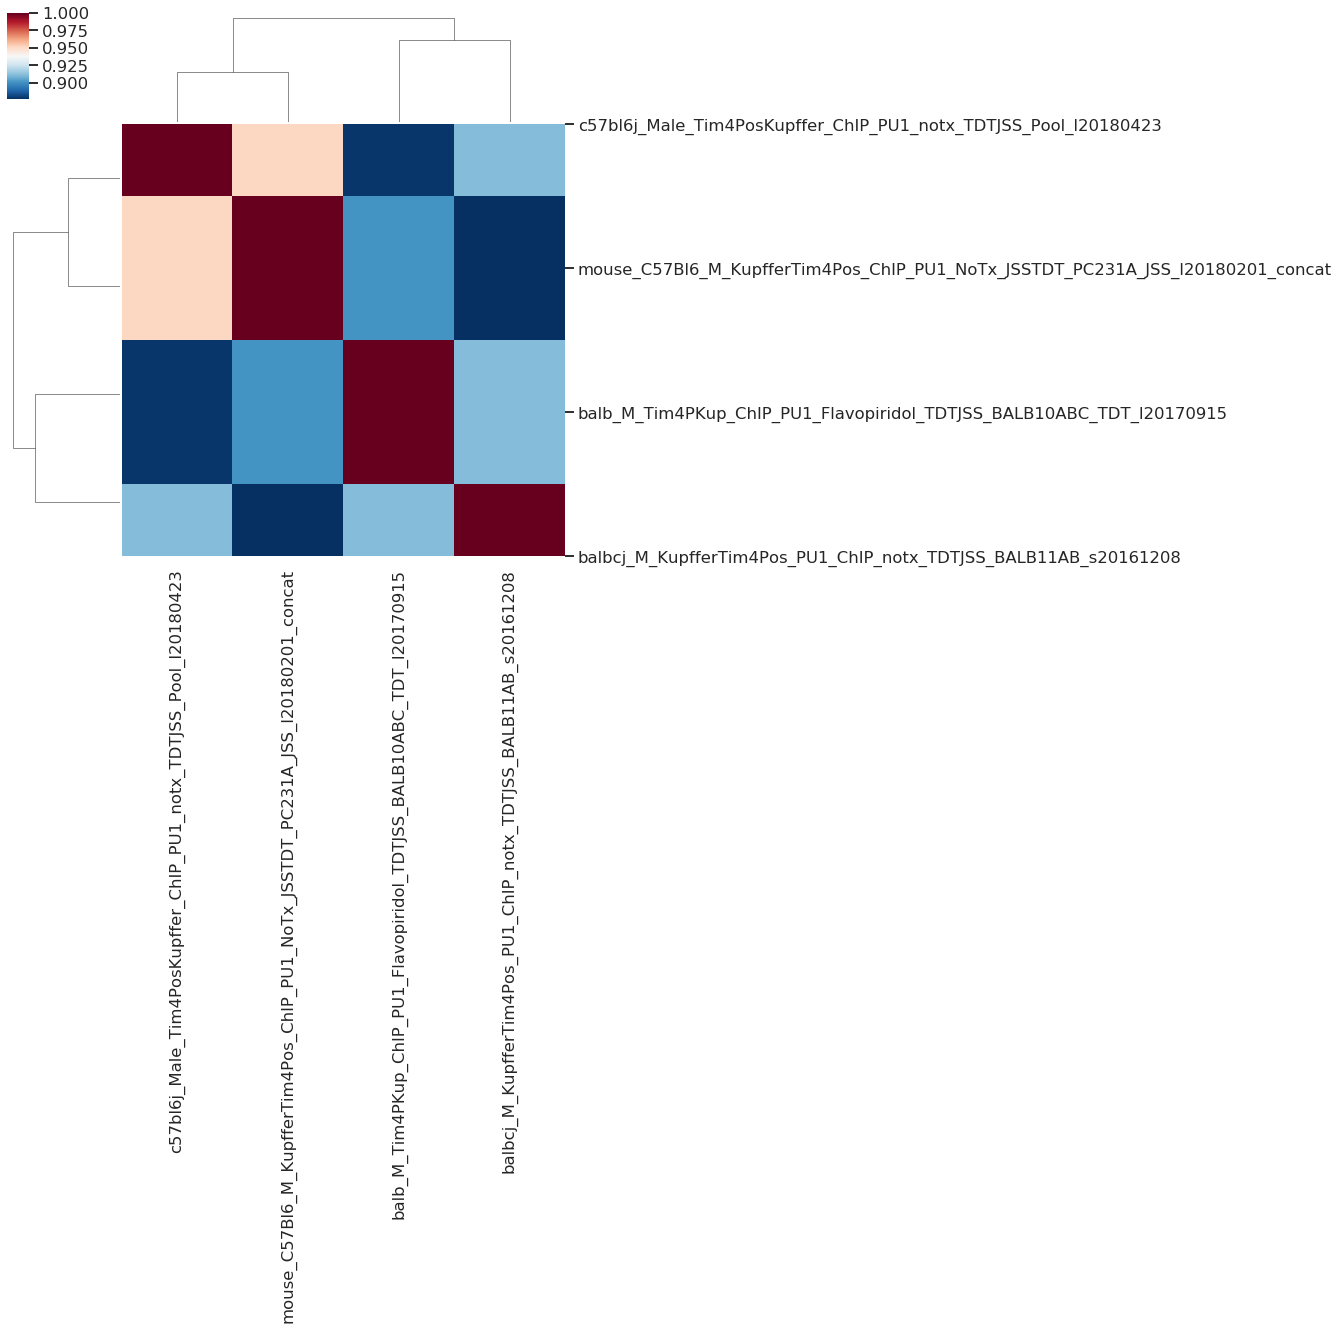

In [34]:
cm = sns.clustermap(mat_quant.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_heatmap_quantnorm.png', bbox_inches='tight')

In [35]:
mat_distal = mat.reindex(df.loc[np.abs(df['Distance to TSS']) >= 3000.0].index.tolist())
mat_distal.dropna(inplace=True)

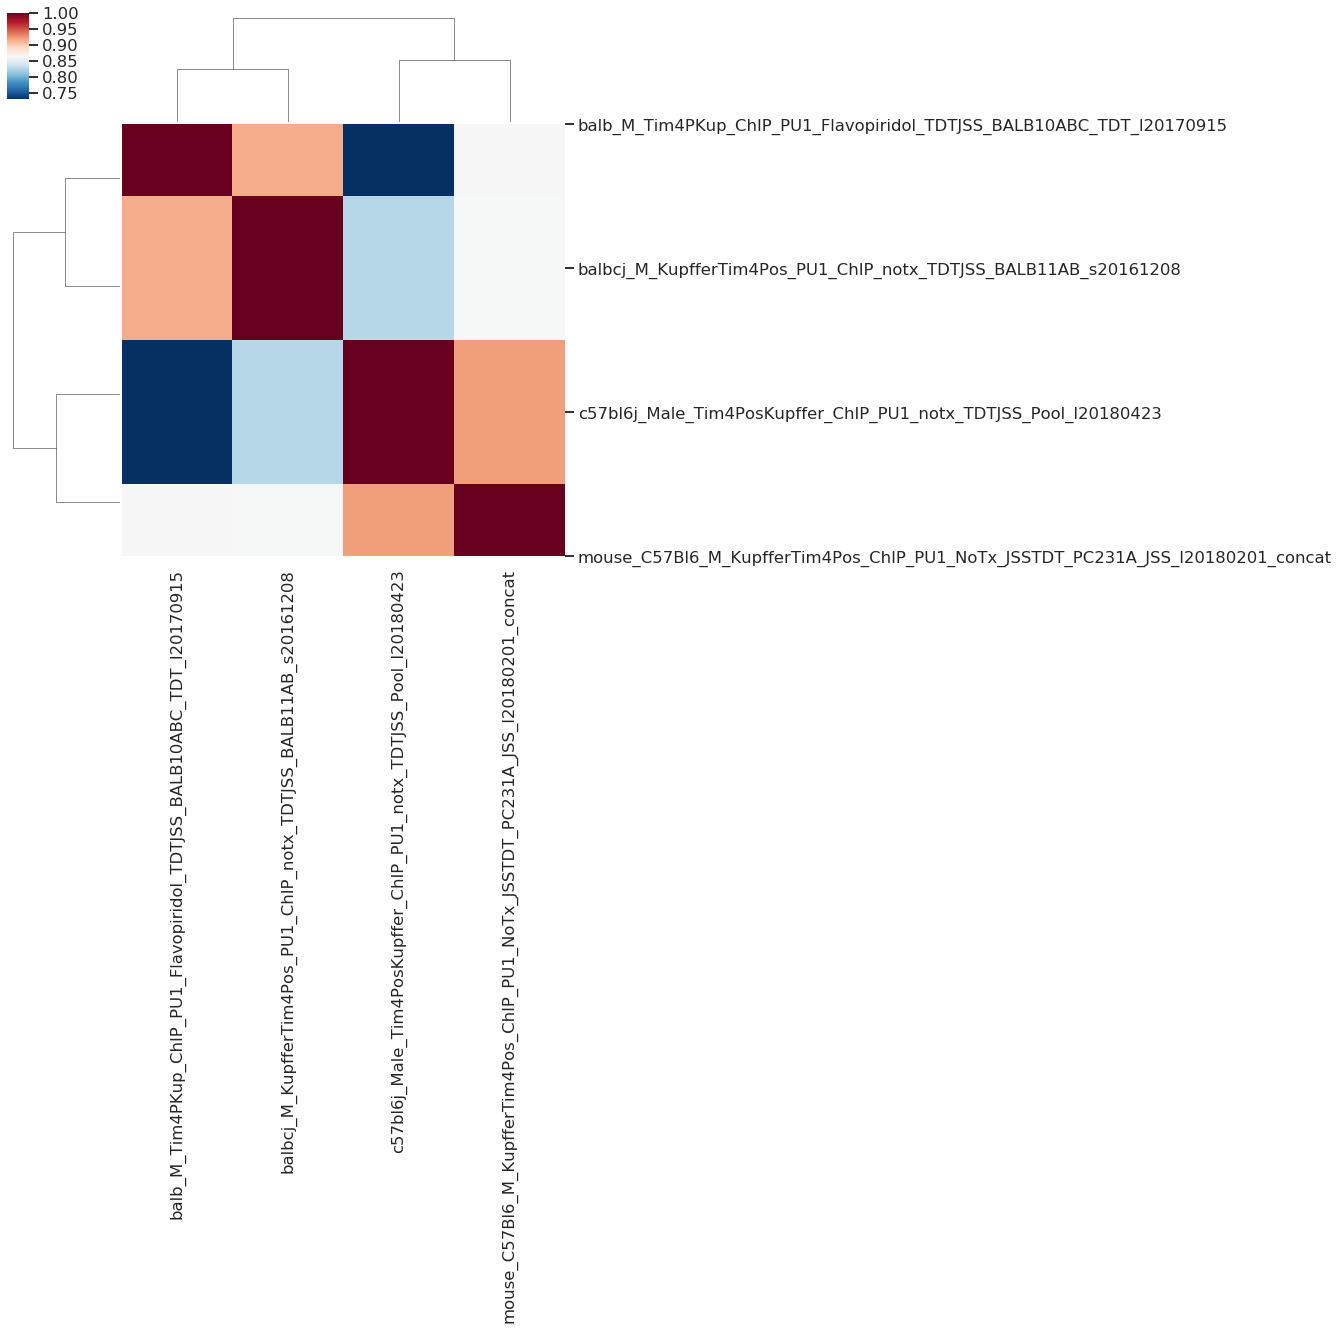

In [36]:
cm = sns.clustermap(mat_distal.corr(), cmap='RdBu_r')
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.savefig('./figures/atac_correlation_distal_heatmap.png', bbox_inches='tight')

# Principal Component Analysis

Create sample ID data frame for ease of plotting

In [41]:
# this part must be done manually - use the sample ID fields to pick out
# identifiers for each sample.
samples = pd.Series(mat.columns.str.split('/').str[-1])
group = samples.str.split('_').str[0]
strain = samples.str.split('_').str[1]
cell = samples.str.split('_').str[2]
treatment = samples.str.split('_').str[4]
treatment_time = samples.str.split('_').str[5]
mouseid = samples.str.split('_').str[7]
sampledate = samples.str.split('_').str[-1]
                                        
samplesDF = pd.DataFrame([pd.Series(samples),
                          pd.Series(group),
                          pd.Series(strain),
                          pd.Series(cell),
                          pd.Series(treatment),
                          pd.Series(treatment_time),
                          pd.Series(mouseid),
                          pd.Series(sampledate)],
                         index=['mouse', 'group', 'strain', 'celltype',
                                'treatment', 'treatment_time', 'mouse_id',
                                'sample_date']).T

In [42]:
samplesDF

,mouse,group,strain,celltype,treatment,treatment_time,mouse_id,sample_date
0,balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_B...,balb,M,Tim4PKup,PU1,Flavopiridol,BALB10ABC,l20170915
1,balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_B...,balbcj,M,KupfferTim4Pos,ChIP,notx,BALB11AB,s20161208
2,c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJ...,c57bl6j,Male,Tim4PosKupffer,PU1,notx,Pool,l20180423
3,mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JS...,mouse,C57Bl6,M,ChIP,PU1,JSSTDT,concat


### Look at PCA plots for all the samples

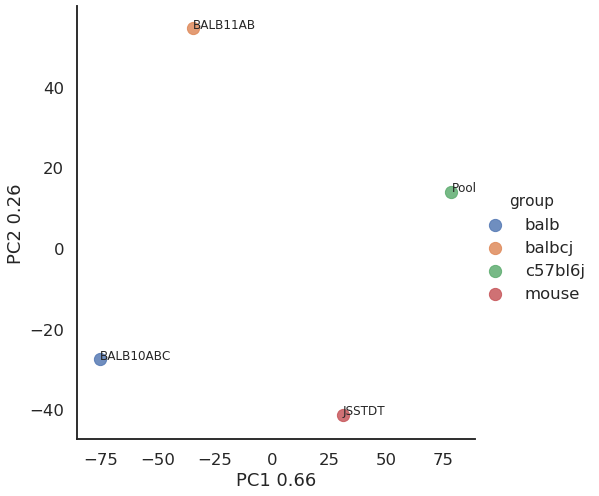

In [43]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2.png', bbox_inches='tight')

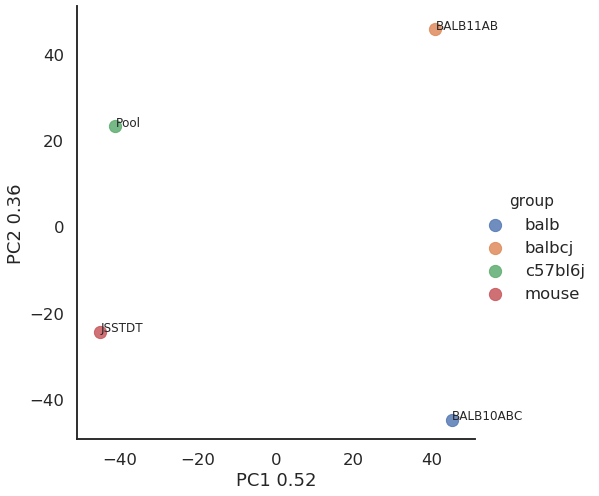

In [44]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_quant,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)
label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_pca1_pca2_quantnorm.png', bbox_inches='tight')

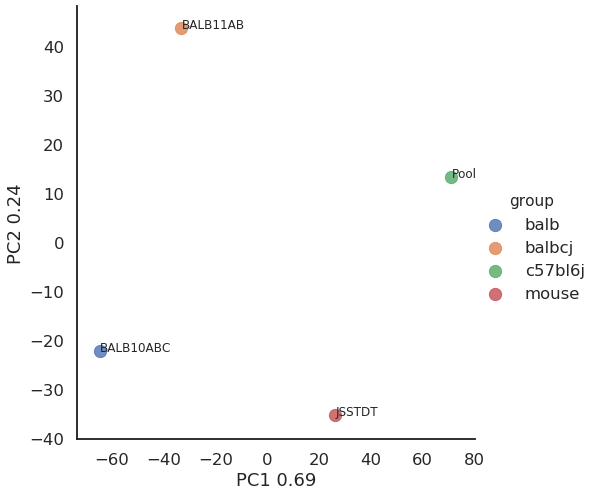

In [45]:
pca, exp_var, pcs = pca_rpkm_mat(rpkm=mat_distal,
                                 group_labels=samplesDF.group,
                                 plot_size=7,
                                 n_pca=3)

label_point(pca.PC1,
            pca.PC2,
            samplesDF.mouse_id,
            plt.gca())

plt.savefig('./figures/atac_distal_pca1_pca2.png', bbox_inches='tight')

# Make Venn Diagram of Poised Enhancers

In [49]:
from matplotlib_venn import venn2

In [50]:
groups = ['BALBcJ', 'C57BL6J']
columns = [[0,1],
           [2,3]]

avg_tags = {}

for group, col in zip(groups, columns):
    avg_tags[group] = mat.iloc[:, col].mean(1)
    
avg_tags_df = pd.DataFrame(avg_tags)

In [51]:
thresh=8

peak_dict = {}
for col in avg_tags_df.columns:
    peak_dict[col] = avg_tags_df.index[avg_tags_df[col]>thresh].tolist()

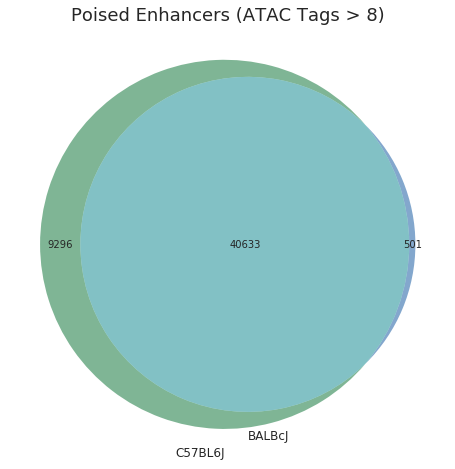

In [54]:
fig, ax = plt.subplots(figsize=(8,8))

# venn3 accepts a list with the following order
# (100, 010, 110, 001, 101, 011, 111)
# group1, group2, group1+2, group3, group1+3, group2+3, group3
venn2(subsets=[set(peak_dict['C57BL6J']),
               set(peak_dict['BALBcJ'])],
      set_colors=('#006d2c', '#08519c'),
      set_labels=('C57BL6J', 'BALBcJ'),
      alpha=0.5,
      ax=ax)
ax.set_title('Poised Enhancers (ATAC Tags > %d)' % thresh);

plt.savefig('./figures/venn3_poised_ATAC_peaks.png', bbox_inches='tight')

# Write 'poised' enhancers out for analysis with HOMER
___
Should use the same threshold as venn diagram above

In [56]:
if not os.path.isdir('./pu1_bound_enhancers/'):
    os.mkdir('./pu1_bound_enhancers/')

Select distal peaks

In [57]:
df_distal = df.loc[np.abs(df['Distance to TSS']) > 3*10**3, :]

if np.NaN get introduced into the matrix then it converts 'int' type columns to 'float' type columns, this is not ideal and interferes with downstream peak analysis so we create a dict to change the start and end columns back to integers just in case

In [58]:
convert_dict = {'Start': int,
                'End': int}

In [59]:
for col in avg_tags_df.columns:
    tmp = df.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./pu1_bound_enhancers/'+col+'_pu1_enhancer_peaks.txt', sep='\t')
    
    tmp = df_distal.reindex(avg_tags_df.index[avg_tags_df[col]>thresh].tolist())
    tmp = tmp.dropna(how='all').iloc[:, :5]
    tmp = tmp.astype(convert_dict)
    tmp.to_csv('./pu1_bound_enhancers/'+col+'_pu1_distal_enhancer_peaks.txt', sep='\t')

# Once we have settled on tag directories for each group we will make merged tag directories for visualization in the genome browser

In [63]:
if not os.path.isdir('./merged_tagdirs/'):
    os.mkdir('./merged_tagdirs/')

In [61]:
!ls /home/h1bennet/strains/data/PU1/control/

aj_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_AJ10ABC_TDT_l20170915
balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208
balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915
c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423
mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat


In [62]:
# grab relevant tag directories
tagdirs = np.sort(['/home/h1bennet/strains/data/PU1/control/mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat',
                   '/home/h1bennet/strains/data/PU1/control/c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423',
                   '/home/h1bennet/strains/data/PU1/control/balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915',
                   '/home/h1bennet/strains/data/PU1/control/balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208'])

drop_files = ['NaN']

# drop files if necessary
tagdirs = pd.Series(tagdirs)[~pd.Series(tagdirs).str.contains('|'.join(drop_files))].tolist()

In [63]:
# might have to adjust this depending on the sample ids
groups = ['c57bl6j', 'balbcj']
tagdirs = [['/home/h1bennet/strains/data/PU1/control/mouse_C57Bl6_M_KupfferTim4Pos_ChIP_PU1_NoTx_JSSTDT_PC231A_JSS_l20180201_concat',
            '/home/h1bennet/strains/data/PU1/control/c57bl6j_Male_Tim4PosKupffer_ChIP_PU1_notx_TDTJSS_Pool_l20180423'],
           ['/home/h1bennet/strains/data/PU1/control/balb_M_Tim4PKup_ChIP_PU1_Flavopiridol_TDTJSS_BALB10ABC_TDT_l20170915',
            '/home/h1bennet/strains/data/PU1/control/balbcj_M_KupfferTim4Pos_PU1_ChIP_notx_TDTJSS_BALB11AB_s20161208']]


In [64]:
with open('./merge_tagdirs.sh', 'w') as f:
    for group, tagdir in zip(groups, tagdirs):
        tagdirs_to_merge = [i for i in tagdirs if group in i]
        merge_call = ['makeTagDirectory',
                      './merged_tagdirs/'+group+'_Kupffer_ATAC_Control_30weeks',
                      '-d \\\n', ' \\\n'.join(tagdirs_to_merge), '\n\n']
        f.write(' '.join(merge_call))
    f.close()

### write command for upload as browser hub

In [62]:
!ls merged_tagdirs

ls: cannot access merged_tagdirs: No such file or directory


Colors chosen as second color from 3 class green, blue, and red on colorbrewer2.org

In [ ]:
%%bash

makeMultiWigHub.pl hrb_strains_viz_atac_merged_control_30weeks mm10 \
-color 161,217,155 158,202,225 252,146,114 \
-force -d ./merged_tagdirs/*